<a href="https://colab.research.google.com/github/inhovation97/Get-an-education-Computer-Vision/blob/main/Image%20Segmentation/DensUnet_tutorial_ImgGenerator_Attention_210715.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import keras
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, BatchNormalization, UpSampling2D
from keras.layers import  Dropout, Activation
from keras.optimizers import Adam, SGD
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import backend as K
from keras.utils import plot_model
import tensorflow as tf
import glob
import random
import cv2
from random import shuffle

Using TensorFlow backend.


# Dataset

We will use the The Oxford-IIIT Pet Dataset. It contains 37 classes of dogs and cats with around 200 images per each class. The dataset contains labels as bounding boxes and segmentation masks. The total number of images in the dataset is a little more than 7K. 

![alt text](http://www.robots.ox.ac.uk/~vgg/data/pets/pet_annotations.jpg)

Download the images/masks and unzip the files 

In [ ]:
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xvzf images.tar.gz && tar -xvzf annotations.tar.gz
!rm  images/*.mat

Note that we have two foulders. The first one is `images` which contains the raw images and annotation which contains the masks as a `binary` foulder image.

# Generators

In [ ]:
import random

def image_generator2(files, batch_size=32, sz=(256,256)):
  n_samples = len(files)
  n_batches = n_samples // batch_size
  indecis = list(np.arange(n_samples))

  while True:
    random.shuffle(files)
    for i in range(n_batches):
      paths = files[i*batch_size:i*batch_size+batch_size]
      batch_x = []
      batch_y = []

      for f in paths:
          #get the masks. Note that masks are png files 
          # Image -> Random -> Read -> Resize (256, 256)
          # path = 'annotations/trimaps/{}.png'.format(f[:-4])
          mask = Image.open(f'annotations/trimaps/{f[:-4]}.png')
          mask = np.array(mask.resize(sz))
          
          #preprocess the binary mask 
          mask[mask >= 2] = 0 
          mask[mask != 0 ] = 1
          
          batch_y.append(mask)

          #preprocess the raw images 
          raw = Image.open(f'images/{f}')
          raw = raw.resize(sz)
          raw = np.array(raw)

          #check the number of channels because some of the images are RGBA or GRAY
          # if GRAY (256, 256) --> Length of Tuple ? 2
          # elif Color (256, 256, 3) --> Length of Tuple ? 3
          #  GRAY ? Color
          # 4D tensor (b, h, w, c)
          if len(raw.shape) == 2:
            raw = np.stack((raw,)*3, axis=-1)

          else:
            raw = raw[:,:,0:3]

          batch_x.append(raw)

      #preprocess a batch of images and masks 
      batch_x = np.array(batch_x)/255.
      batch_y = np.array(batch_y)
      # (32, 256, 256)
      batch_y = np.expand_dims(batch_y,-1)
      # (32, 256, 256, 1)

      yield (batch_x, batch_y) 


In [ ]:
batch_size = 32

all_files = os.listdir('images')
# get all files in images folder
# list 
shuffle(all_files)

# len(all_files) -> N? 
# 0.95 -> training, 0.05 --> Validation
split = int(0.95 * len(all_files))

#split into training and testing
train_files = all_files[0:split]
test_files  = all_files[split:]

train_generator = image_generator2(train_files, batch_size = batch_size)
test_generator  = image_generator2(test_files, batch_size = batch_size)

In [ ]:
x, y= next(train_generator)
print (x.shape, y.shape)

(32, 256, 256, 3) (32, 256, 256, 1)


In [ ]:
# Numpy N-dims Array X
# image, image -> 4D tensor (B, H, W, C) or (B, C, H, W)
# Image_generator
#  U-Net Input 2*n
def image_generator(files, batch_size = 32, sz = (256, 256)):

  while True: 
    
    # image file 중 32장을 랜덤하게 골라라
    # 32개의 index를 뽑아 줍니다. 
    batch = np.random.choice(files, size = batch_size)

    # list for Image, Mask
    batch_x = []
    batch_y = []
    
    # batch -> list
    for f in batch:
        #get the masks. Note that masks are png files 
        # Image -> Random -> Read -> Resize (256, 256)
        # path = 'annotations/trimaps/{}.png'.format(f[:-4])
        mask = Image.open(f'annotations/trimaps/{f[:-4]}.png')
        mask = np.array(mask.resize(sz))
        
        #preprocess the binary mask 
        mask[mask >= 2] = 0 
        mask[mask != 0 ] = 1
        
        batch_y.append(mask)

        #preprocess the raw images 
        raw = Image.open(f'images/{f}')
        raw = raw.resize(sz)
        raw = np.array(raw)

        #check the number of channels because some of the images are RGBA or GRAY
        # if GRAY (256, 256) --> Length of Tuple ? 2
        # elif Color (256, 256, 3) --> Length of Tuple ? 3
        #  GRAY ? Color
        # 4D tensor (b, h, w, c)
        if len(raw.shape) == 2:
          raw = np.stack((raw,)*3, axis=-1)

        else:
          raw = raw[:,:,0:3]

        batch_x.append(raw)

    #preprocess a batch of images and masks 
    batch_x = np.array(batch_x)/255.
    batch_y = np.array(batch_y)
    # (32, 256, 256)
    batch_y = np.expand_dims(batch_y,-1)
    # (32, 256, 256, 1)

    yield (batch_x, batch_y)    
    
    # batch_x: 32, 256, 256, 3
    # batch_y: 32, 256, 256, 1 

In [ ]:
batch_size = 32

all_files = os.listdir('images')
# get all files in images folder
# list 
shuffle(all_files)

# len(all_files) -> N? 
# 0.95 -> training, 0.05 --> Validation
split = int(0.95 * len(all_files))

#split into training and testing
train_files = all_files[0:split]
test_files  = all_files[split:]

train_generator = image_generator(train_files, batch_size = batch_size)
test_generator  = image_generator(test_files, batch_size = batch_size)

In [ ]:
x, y= next(train_generator)

In [ ]:
print (x.shape, y.shape)

(32, 256, 256, 3) (32, 256, 256, 1)


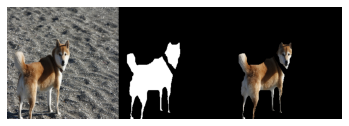

In [ ]:
plt.axis('off')
img = x[0]
# (256, 256, 3)
msk = y[0].squeeze()
# (256, 256, 1) --> (256, 256)

msk = np.stack((msk,)*3, axis=-1)
# Image (256, 256, 3) * Mask (256, 256, 3)

plt.imshow( np.concatenate([img, msk, img*msk], axis = 1))

# IoU metric

The intersection over union (IoU) metric is a simple metric used to evaluate the performance of a segmentation algorithm. Given two masks $y_{true}, y_{pred}$ we evaluate 

$$IoU = \frac{y_{true} \cap y_{pred}}{y_{true} \cup y_{pred}}$$

In [ ]:
def mean_iou(y_true, y_pred):
    yt0 = y_true[:,:,:,0]
    yp0 = K.cast(y_pred[:,:,:,0] > 0.5, 'float32')
    inter = tf.count_nonzero(tf.logical_and(tf.equal(yt0, 1), tf.equal(yp0, 1)))
    union = tf.count_nonzero(tf.add(yt0, yp0))
    iou = tf.where(tf.equal(union, 0), 1., tf.cast(inter/union, 'float32'))
    return iou

In [ ]:
from keras.losses import binary_crossentropy

def dice_coef(y_true, y_pred, smooth=0.00001):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    smooth = 0.00001
    y_pred = K.cast(y_pred[:,:,:,0] > 0.5, 'float32')
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred) 

# Model

In [ ]:
def conv_block(x, nkernels):
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv2D(nkernels, (3,3), kernel_initializer='he_normal', use_bias=False, padding='same') (x)
  
  return x

In [ ]:
def residual_block(x, nkernels):
  identity = x

  x = conv_block(x, nkernels)
  x = conv_block(x, nkernels)
  
  return keras.layers.Add()([x + identity])

In [ ]:
def dense_block(x0, growth_rate=4):

  x1 = conv_block(x0, growth_rate)
  x1c = Concatenate(axis=-1)([x0, x1])

  x2 = conv_block(x1c, growth_rate)
  x2c = Concatenate(axis=-1)([x0, x1, x2])

  x3 = conv_block(x2c, growth_rate)
  x3c = Concatenate(axis=-1)([x0, x1, x2, x3])

  x4 = conv_block(x3c, growth_rate)
  x4c = Concatenate(axis=-1)([x0, x1, x2, x3, x4])

  # Transition Layer
  ouput = Conv2D(growth_rate, (1,1), kernel_initializer='he_normal', padding='same') (x4c)

  return ouput

In [ ]:
def spatial_attention_block(x0):
  x1 = x0
  x1 = Conv2D(1, (1,1), padding='same') (x1)
  x1 = Activation('sigmoid')(x1)
  return keras.layers.Multiply()([x0, x1])

In [ ]:
def squeeze_and_excitation_block(x0, ratio=16):
  n_channel = int(x0.shape[-1])
  x1 = x0
  x1 = keras.layers.GlobalAveragePooling2D()(x1)
  x1 = keras.layers.Reshape((1,1,n_channel))(x1)
  x1 = keras.layers.Dense(n_channel//ratio)(x1)
  x1 = Activation('relu')(x1)
  x1 = keras.layers.Dense(n_channel)(x1)
  x1 = Activation('sigmoid')(x1)

  return keras.layers.Multiply()([x0, x1])


In [ ]:
def unet(sz = (256, 256, 3)):
  x = Input(sz)
  inputs = x
  
  #down sampling 
  nkernels = 64 
  growth_rate = 4
  # number of output feature

  # encoding
  encoded = conv_block(x, 64)
  # residual block
  # 256, 256, 64
  layer11 = dense_block(encoded, 4)
  layer11 = squeeze_and_excitation_block(layer11, ratio=2)
  layer11 = spatial_attention_block(layer11)
  # 256, 256, 4
  layer12 = MaxPooling2D()(layer11)
  # 128, 128, 4

  layer21 = dense_block(layer12, 4)
  layer21 = squeeze_and_excitation_block(layer21, ratio=2)
  layer22 = MaxPooling2D()(layer21)

  layer31 = dense_block(layer22, 4)
  layer31 = squeeze_and_excitation_block(layer31, ratio=2)
  layer32 = MaxPooling2D()(layer31)

  layer41 = dense_block(layer32, 4)
  layer41 = squeeze_and_excitation_block(layer41, ratio=2)
  layer42 = MaxPooling2D()(layer41)

  Bottleneck1 = Conv2D(128, (3,3), activation='relu', padding='same')(layer42)
  Bottleneck1 = squeeze_and_excitation_block(Bottleneck1, ratio=2)
  Bottleneck2 = Conv2D(64, (3,3), activation='relu', padding='same')(Bottleneck1)

  layer42up = UpSampling2D()(Bottleneck2)
  layer43 = Concatenate(axis=-1)([layer41, layer42up])
  layer44 = dense_block(layer43, 4)
  layer44 = squeeze_and_excitation_block(layer44, ratio=2)


  layer45up = UpSampling2D()(layer44)
  layer33 = Concatenate(axis=-1)([layer31, layer45up])
  layer34 = dense_block(layer33, 4)
  layer34 = squeeze_and_excitation_block(layer34, ratio=2)

  layer35up = UpSampling2D()(layer34)
  layer23 = Concatenate(axis=-1)([layer21, layer35up])
  layer24 = dense_block(layer23, 4)
  layer24 = squeeze_and_excitation_block(layer24, ratio=2)

  layer25up = UpSampling2D()(layer24)
  layer13 = Concatenate(axis=-1)([layer11, layer25up])
  layer14 = dense_block(layer13, 4)
  layer14 = squeeze_and_excitation_block(layer14, ratio=2)

  last = Conv2D(1, (3,3), activation='relu', padding='same')(layer14)

  #model creation 
  model = Model(inputs=[inputs], outputs=[last])
  model.compile(optimizer = 'rmsprop', loss = bce_dice_loss, metrics = [mean_iou])
  
  return model

In [ ]:
model = unet()

# Callbacks

Simple functions to save the model at each epoch and show some predictions 

In [ ]:
def build_callbacks():
        checkpointer = ModelCheckpoint(filepath='unet.h5', verbose=0, save_best_only=True, save_weights_only=True)
        callbacks = [checkpointer, PlotLearning()]
        return callbacks

# inheritance for training process plot 
class PlotLearning(keras.callbacks.Callback):

    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        #self.fig = plt.figure()
        self.logs = []
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('mean_iou'))
        self.val_acc.append(logs.get('val_mean_iou'))
        self.i += 1
        print('i=',self.i,'loss=',logs.get('loss'),'val_loss=',logs.get('val_loss'),'mean_iou=',logs.get('mean_iou'),'val_mean_iou=',logs.get('val_mean_iou'))
        
        #choose a random test image and preprocess
        path = np.random.choice(test_files)
        raw = Image.open(f'images/{path}')
        raw = np.array(raw.resize((256, 256)))/255.
        raw = raw[:,:,0:3]
        
        #predict the mask 
        pred = model.predict(np.expand_dims(raw, 0))
        
        #mask post-processing 
        msk  = pred.squeeze()
        msk = np.stack((msk,)*3, axis=-1)
        msk[msk >= 0.5] = 1 
        msk[msk < 0.5] = 0 
        
        #show the mask and the segmented image 
        combined = np.concatenate([raw, msk, raw* msk], axis = 1)
        plt.axis('off')
        plt.imshow(combined)
        plt.show()

# Training

In [ ]:
train_steps = len(train_files) //batch_size
test_steps = len(test_files) //batch_size
model.fit_generator(train_generator, 
                    epochs = 30, steps_per_epoch = train_steps,validation_data = test_generator, validation_steps = test_steps,
                    callbacks = build_callbacks(), verbose = 0)

# Testing

In [ ]:
!wget http://r.ddmcdn.com/s_f/o_1/cx_462/cy_245/cw_1349/ch_1349/w_720/APL/uploads/2015/06/caturday-shutterstock_149320799.jpg -O test.jpg

--2021-07-14 13:22:48--  http://r.ddmcdn.com/s_f/o_1/cx_462/cy_245/cw_1349/ch_1349/w_720/APL/uploads/2015/06/caturday-shutterstock_149320799.jpg
Resolving r.ddmcdn.com (r.ddmcdn.com)... 99.86.116.62, 99.86.116.20, 99.86.116.81, ...
Connecting to r.ddmcdn.com (r.ddmcdn.com)|99.86.116.62|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 63219 (62K) [image/jpeg]
Saving to: ‘test.jpg’

test.jpg            100%[===================>]  61.74K  --.-KB/s    in 0.01s   

2021-07-14 13:22:48 (6.07 MB/s) - ‘test.jpg’ saved [63219/63219]



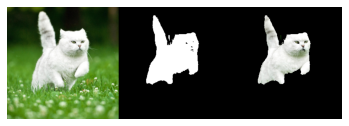

In [ ]:
raw = Image.open('test.jpg')
raw = np.array(raw.resize((256, 256)))/255.
raw = raw[:,:,0:3]

#predict the mask 
pred = model.predict(np.expand_dims(raw, 0))

#mask post-processing 
msk  = pred.squeeze()
msk = np.stack((msk,)*3, axis=-1)
msk[msk >= 0.5] = 1 
msk[msk < 0.5] = 0 

#show the mask and the segmented image 
combined = np.concatenate([raw, msk, raw* msk], axis = 1)
plt.axis('off')
plt.imshow(combined)
plt.show()

# References


1.   http://deeplearning.net/tutorial/unet.html
2.   https://github.com/ldenoue/keras-unet

